In [0]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

In [0]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm

from IPython import display

In [0]:
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving movingmnistdata.npz to movingmnistdata (3).npz


In [0]:
movingmnist = np.load('movingmnistdata (2).npz');
data = movingmnist['arr_0']
print(data.shape)
len(data)

(60000, 1, 64, 64)


60000

In [0]:
from torch.utils.data.dataset import Dataset

class movingMNIST(Dataset):
    def __init__(self, dataset , transform = None ):
      
      self.data = dataset.f.arr_0.transpose(0,3,2,1)
      
      self.transform = transform
        
    def __getitem__(self, index):
      image = self.data[index]
      if self.transform is not None:
            image = self.transform(image)

      return image

    def __len__(self): 
      return len(self.data)

In [0]:
def prepare_dataset():
  
  train_data = np.load('movingmnistdata (2).npz');
  test_data = np.load('movingmnistdata (2).npz');

  train_dataset = movingMNIST(train_data, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
  test_dataset = movingMNIST(test_data, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=8, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size=8, shuffle=True)
  
  return train_loader, test_loader, train_dataset, test_dataset

In [0]:
train_loader, test_loader, train_dataset, test_dataset = prepare_dataset()
# for batch_idx, data in enumerate(train_loader):
#   print(batch_idx, data)

In [0]:
class VAE_encoder(nn.Module):
    def __init__(self):
        super(VAE_encoder, self).__init__()
        intermediate_channels = 32
        z_dims = 128
        self.conv1 = nn.Conv2d(1, intermediate_channels, kernel_size=5, stride=2, padding=2, bias=True)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=5, stride=2, padding=2, bias=True)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv4 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=2, padding=1, bias=True)

        
        self.conv_mu = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        self.conv_logvar = nn.Conv2d(intermediate_channels, z_dims, kernel_size=2, stride=1, padding=0)
        
 
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.bn3 = nn.BatchNorm2d(intermediate_channels)
        self.bn4 = nn.BatchNorm2d(intermediate_channels)
        self.bn5 = nn.BatchNorm2d(intermediate_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv4(x)))

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)

        return mu, logvar
    def rsample(self, mu, logvar):
        m = torch.distributions.Normal(mu, torch.exp(logvar * 0.5))
        return m.rsample()

In [0]:
class VAE_decoder(nn.Module):
    def __init__(self):
        super(VAE_decoder, self).__init__()
        intermediate_channels = 32
        self.conv1 = nn.Conv2d(128, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1,bias=True)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1,bias=True)
        self.conv4 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1,bias=True)
        self.conv5 = nn.Conv2d(intermediate_channels, 1, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        x = F.elu(self.conv1(F.interpolate(x, scale_factor=2)))
        x = F.elu(self.conv2(F.interpolate(x, scale_factor=4)))
        x = F.elu(self.conv3(F.interpolate(x, scale_factor=2)))
        x = F.elu(self.conv4(F.interpolate(x, scale_factor=2)))
        x = self.conv5(F.interpolate(x, scale_factor=2))
        return x

In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = VAE_encoder()
    self.decoder = VAE_decoder()
    
  def forward(self,x):
    mu, logvar = self.encoder(x)
    latent = self.encoder.rsample(mu, logvar)
    
    reconstruction = self.decoder(latent)
    
    return mu, logvar, latent, reconstruction
    

torch.Size([1, 1, 64, 64])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 4, 4])
torch.Size([1, 32, 2, 2])
torch.Size([1, 128, 1, 1]) torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 1, 1]) torch.Size([1, 128, 1, 1]) torch.Size([1, 128, 1, 1]) torch.Size([1, 1, 64, 64])
(64, 64)


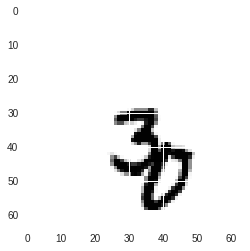

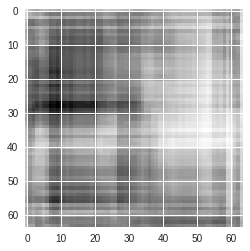

In [0]:
model = VAE()

mu, logvar, latent, reconstruction = model(train_dataset[0].unsqueeze(0))
print(mu.shape, logvar.shape, latent.shape, reconstruction.shape)


image = train_dataset[0].view(64, 64).data.numpy()
print(image.shape)

plt.imshow(image)

recons_image = reconstruction.view(64, 64).data.numpy()
plt.figure()
plt.imshow(recons_image)




In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
#     print(recon_x.shape, x.shape)
    BCE = F.cross_entropy(recon_x.view(-1, 4096), x.view(-1, 4096).long(), reduction='sum') #TODO-----------------------

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  #TODO-----------------------

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader): #TODO-----------------------
        data = data.to(device)
        optimizer.zero_grad()
        mu, logvar, latent, recon_batch = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:   #TODO-----------------------
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):  #TODO-----------------------
            data = data.to(device)
            mu, logvar, latent, recon_batch = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], 
                                      recon_batch.view(8, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [0]:
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

In [0]:
# Run experiment

epochs = 10

for epoch in range(1, epochs+1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 64,64),
                   'results/sample_' + str(epoch) + '.png')

RuntimeError: ignored